In [ ]:
"""
Purpose: 
To explore whether there is a distribution bias for the 
orientation preferences of cells in the L2/L3 are of
the mouse visual cortex
"""

In [1]:
import numpy as np
import datajoint as dj
import pycircstat as pycs
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [2]:
# ********************load the data from local file******************
rad2deg = 180/np.pi

import numpy as np
import datajoint as dj

orientation_center_data = np.load("orientation_center_data.npz",allow_pickle=True)
orientation_center_data.files
soma_cell_data = orientation_center_data["soma_cell_data"] #stores the soma id, segment_id and the x,y,z coordinates as well as the cell_class = excitatory
orientation_preference = orientation_center_data["orientation_preference"] #the orientation preferences in radians that correspond tot he 
seg_ids = orientation_center_data["seg_ids"] #the segment ids for the orientation preferences

#build a lookup dictionary for segment ids to orientation
seg_id_to_orientation = dict([(seg_ids[k],orientation_preference[k]) for k in range(0,len(seg_ids))])
#seg_id_to_orientation

"""Turns the downloaded table of soma data into a dictionary with the segment_id as the key"""
soma_cell_data
soma_cell_location_dict = dict([(k["segment_id"],dict(location=np.array([k["soma_x"],k["soma_y"],k["soma_z"]]),x_loc=k["soma_x"],y_loc=k["soma_y"],z_loc=k["soma_z"])) for k in soma_cell_data])
#soma_cell_location_dict

# Computing Dictionary that will Compute Pairwise Distances Between Neurons:

In [3]:
"""create a 2D array that has the distances between each cell pair
Includes the:
1) overall distance 
2) Distance along each axis
"""
from tqdm import tqdm

soma_distance_array = dict()

# For computing the distance scalings
total_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
mins = np.min(total_list,axis=0) 
maxs = np.max(total_list,axis=0)
min_max_ranges = maxs - mins
scalings = min_max_ranges/min_max_ranges[-1]

for seg_1 in tqdm(soma_cell_location_dict.keys()):
    for seg_2 in soma_cell_location_dict.keys():
        location_1 = soma_cell_location_dict[seg_1]["location"]
        location_2 = soma_cell_location_dict[seg_2]["location"]
        if seg_1 not in soma_distance_array.keys():
            soma_distance_array[seg_1] = dict()
        
        soma_distance_array[seg_1][seg_2] = dict(distance=np.linalg.norm(location_1-location_2),
                                                 x_distance = location_1[0] - location_2[0], 
                                                 y_distance = location_1[1] - location_2[1], 
                                                 z_distance = location_1[2] - location_2[2],
                                                distance_scaled =np.linalg.norm((location_1-location_2)/scalings),
                                                 x_distance_scaled = (location_1[0] - location_2[0])/scalings[0], 
                                                 y_distance_scaled = (location_1[1] - location_2[1])/scalings[1], 
                                                 z_distance_scaled = (location_1[2] - location_2[2])/scalings[2]
                                                )


100%|██████████| 75/75 [00:00<00:00, 289.41it/s]


In [20]:
# Setting the parameter about whether volume should be scaled
scale_flag = True
#scaled=scale_flag

# Functions for finding subgroups

In [12]:
# how to retrieve subgroups on scaling basis
# Functions that will find the subgroup:

def find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width=13000,
                         box_height=13000,scaled=False):
    """
    Returns the list of ids for neurons in a column
    Speicifed by the parameters
    """
    if scaled == False:
        column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
                                                                          and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_height))]
        return column_neurons
    else:
        column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis+"_scaled"]) < box_width)
                                                                      and (abs(soma_distance_array[target_neuron][k][height_axis+"_scaled"]) < box_height))]
        return column_neurons
        

def find_radius_subgroup(target_neuron,
                        total_neurons_list,
                        circular_radius=15000,
                        scaled=False):
    """
    Returns the list of ids for neurons in a column
    Speicifed by the parameters
    """
    if scaled == False:
        circular_radius_neurons = [k for k in total_neurons_list if np.abs(soma_distance_array[target_neuron][k]["distance"]) < circular_radius ]
        return circular_radius_neurons
    else:
        circular_radius_neurons = [k for k in total_neurons_list if np.abs(soma_distance_array[target_neuron][k]["distance_scaled"]) < circular_radius ]
        return circular_radius_neurons

# def find_column_subgroup_scaled(width_axis ,
#                          height_axis,
#                         target_neuron,
#                         total_neurons_list,
#                         box_width=13000,
#                          box_height=13000):
#     """
#     Returns the list of ids for neurons in a column
#     Speicifed by the parameters
#     """
#     column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis+"_scaled"]) < box_width)
#                                                                       and (abs(soma_distance_array[target_neuron][k][height_axis+"_scaled"]) < box_height))]
#     return column_neurons

# def find_radius_subgroup_scaled(target_neuron,
#                         total_neurons_list,
#                         circular_radius=15000):
#     """
#     Returns the list of ids for neurons in a column
#     Speicifed by the parameters
#     """
    
#     circular_radius_neurons = [k for k in total_neurons_list if np.abs(soma_distance_array[target_neuron][k]["distance_scaled"]) < circular_radius ]
#     return circular_radius_neurons


# Finding Appropriate Thresholds for Subgroups

In [13]:
circular_radius = 1000

box_width = 1000

suitable_number_threshold = 10
total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)
        circular_radius_neurons = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)
        
        #circular_radius_neurons = [k for k in total_neurons_list if soma_distance_array[target_neuron][k]["distance"] < circular_radius ]
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(circular_radius_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        circular_radius += 100
        total_neurons_in_cluster = []
        
    
print("total_neurons_in_cluster = " + str(total_neurons_in_cluster))
print("Final circular_radius for circular  = " + str(circular_radius))

"""
Final size: suitable number would be 15000
"""


suitable_number_threshold = 10
box_width = 50
width_axis = "x_distance"
height_axis = "y_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

#         column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
#                                                                       and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
        
        column_neurons = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,
                            box_width=box_width,
                             box_height=box_width,scaled=scale_flag)
        
        
        #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster Z AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  Z AXIS = " + str(box_width))

suitable_number_threshold = 10
box_width = 50
width_axis = "y_distance"
height_axis = "z_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

#         column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
#                                                                       and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
#         #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))

        column_neurons = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,
                    box_width=box_width,
                     box_height=box_width,scaled=scale_flag)
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster X AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  X AXIS = " + str(box_width))

suitable_number_threshold = 10
box_width = 50
width_axis = "x_distance"
height_axis = "z_distance"

total_neurons_in_cluster = []

suitable_number = False
while suitable_number == False:
    for target_neuron in list(soma_cell_location_dict.keys()):
        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

#         column_neurons = [k for k in total_neurons_list if ((abs(soma_distance_array[target_neuron][k][width_axis]) < box_width)
#                                                                       and (abs(soma_distance_array[target_neuron][k][height_axis]) < box_width))]
#         #print("len(circular_radius_neurons) = " + str(len(circular_radius_neurons)))

        column_neurons = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,
                    box_width=box_width,
                     box_height=box_width,scaled=scale_flag)
    
        total_neurons_in_cluster.append(len(column_neurons))

        """
        Example of how to find neurons within x column
        """
    # evaluate if enough neurons in each cluster (if 90 percent have 10 or more)
    percentage_above_threshold = np.sum(np.array(total_neurons_in_cluster) >= suitable_number_threshold)/len(total_neurons_in_cluster)
    if percentage_above_threshold >= 0.9:
        suitable_number = True
    else:
        box_width += 50
        total_neurons_in_cluster = []

#print the suitable threshold
print("total_neurons_in_cluster Y AXIS = " + str(total_neurons_in_cluster))
print("Final box_width for circular  Y AXIS = " + str(box_width))



total_neurons_in_cluster = [17, 14, 16, 10, 25, 10, 19, 15, 25, 24, 19, 17, 23, 28, 19, 24, 15, 22, 16, 21, 8, 20, 10, 22, 13, 19, 12, 19, 18, 28, 21, 19, 17, 23, 30, 11, 21, 12, 14, 28, 22, 20, 12, 28, 24, 10, 30, 21, 16, 13, 21, 18, 20, 15, 17, 21, 6, 12, 10, 5, 24, 23, 21, 17, 15, 19, 9, 10, 9, 15, 16, 11, 20, 9, 9]
Final circular_radius for circular  = 13700
total_neurons_in_cluster Z AXIS = [14, 14, 14, 11, 24, 12, 17, 12, 23, 23, 20, 16, 23, 27, 18, 24, 14, 22, 16, 19, 9, 18, 9, 21, 13, 18, 12, 18, 18, 26, 20, 20, 17, 22, 29, 12, 21, 10, 11, 26, 21, 16, 12, 27, 23, 10, 31, 22, 17, 12, 21, 17, 15, 16, 17, 21, 6, 10, 10, 5, 22, 22, 21, 14, 14, 19, 9, 8, 7, 13, 14, 11, 22, 10, 10]
Final box_width for circular  Z AXIS = 11900
total_neurons_in_cluster X AXIS = [13, 2, 9, 20, 21, 20, 21, 15, 12, 16, 13, 20, 19, 20, 19, 21, 19, 18, 20, 11, 12, 19, 14, 20, 16, 17, 19, 21, 18, 18, 18, 12, 19, 10, 12, 3, 20, 21, 17, 20, 12, 10, 11, 15, 17, 12, 13, 10, 13, 10, 12, 12, 13, 12, 12, 20, 1, 13,

In [14]:
"""
Conclusion: The best parameters FOR SCALED
Final circular_radius for circular  = 13700
Final box_width for circular  X AXIS = 2850
Final box_width for circular  Y AXIS = 6600
Final box_width for circular  Z AXIS = 11900

Conclusion: The best parameters FOR SCALED
Final circular_radius for circular  = 1000
Final box_width for circular  X AXIS = 600
Final box_width for circular  Y AXIS = 600
Final box_width for circular  Z AXIS = 600
"""

'\nConclusion: The best parameters FOR SCALED\nFinal circular_radius for circular  = 13700\nFinal box_width for circular  X AXIS = 2850\nFinal box_width for circular  Y AXIS = 6600\nFinal box_width for circular  Z AXIS = 11900\n\nConclusion: The best parameters FOR SCALED\nFinal circular_radius for circular  = 1000\nFinal box_width for circular  X AXIS = 600\nFinal box_width for circular  Y AXIS = 600\nFinal box_width for circular  Z AXIS = 600\n'

# How to compute different thresholds for different tests for subgroups (Same number of Nuerons, Same volume....)

In [15]:
#original volume dimensions
x_box = 250000
y_box = 140000
z_box = 90000


# test 2 (more strict to try and keep around 10 neurons for at least 90 %)
y_width = y_height = 6600
z_width = z_height = 11900
x_width = x_height = 2850
circular_radius = 13700

# calculate the total volume for certain parameters
y_col_volume = (2*y_width) * (2*y_height) * y_box
x_col_volume = (2*x_width) * (2*x_height) * x_box
z_col_volume = (2*z_width) * (2*z_height) * z_box
sphere_volume = 4.0/3.0*np.pi*(circular_radius**3)

print(f"y_col_volume = {y_col_volume} \
\nx_col_volume = {x_col_volume}\
\nz_col_volume = {z_col_volume}\
\nsphere_volume = {sphere_volume}")


print("\n\nThe relative scaling")
print(f"y_col_volume = {y_col_volume/sphere_volume} \
\nx_col_volume = {x_col_volume/sphere_volume}\
\nz_col_volume = {z_col_volume/sphere_volume}\
\nsphere_volume = {sphere_volume/sphere_volume}")

# find scaling factors to make everyone the same volume
def get_extra_width(final_volume,current_height,current_width):
    extra_width = np.sqrt((final_volume)/current_height)/2 - current_width
    return extra_width
#     if extra_width < 0:
#         return - np.sqrt(np.abs(extra_width))
#     else:
#         return np.sqrt(np.abs(extra_width))
    

y_extra_width = get_extra_width(sphere_volume,y_box,y_width)
#check that the height will now be the same
y_new_width = y_width + y_extra_width


x_extra_width = get_extra_width(sphere_volume,x_box,x_width)
#check that the height will now be the same
x_new_width = x_width + x_extra_width

z_extra_width = get_extra_width(sphere_volume,z_box,z_width)
#check that the height will now be the same
z_new_width = z_width + z_extra_width

"""
4*w*h*box + 8*extra*h*ybox + 4*extra^2*y_box = new_volume
8*extra*width + 4*extra**2 = (new_volum - current_volume)/y_box

"""

print("\n New volume scales")
y_col_volume_new = (2*y_new_width) * (2*y_new_width) * y_box
z_col_volume_new = (2*z_new_width) * (2*z_new_width) * z_box
x_col_volume_new = (2*x_new_width) * (2*x_new_width) * x_box
print(y_col_volume_new/sphere_volume,z_col_volume_new/sphere_volume,x_col_volume_new/sphere_volume)

print("\n New widths for exact same volume")
print("y_new_width = " + str(y_new_width))
print("z_new_width = " + str(z_new_width))
print("x_new_width = " + str(x_new_width))

# How could we add different scaling to make sure holds true
scale_factor = 2
circular_radius_scaled = (scale_factor**(1/3))*circular_radius
y_new_width_scaled = (scale_factor**(1/2))*y_new_width
z_new_width_scaled = (scale_factor**(1/2))*z_new_width
x_new_width_scaled = (scale_factor**(1/2))*x_new_width

y_col_volume_scaled = (2*y_new_width_scaled) * (2*y_new_width_scaled) * y_box
z_col_volume_scaled = (2*z_new_width_scaled) * (2*z_new_width_scaled) * z_box
x_col_volume_scaled = (2*x_new_width_scaled) * (2*x_new_width_scaled) * x_box
sphere_volume_scaled = (4.0/3.0)*np.pi*(circular_radius_scaled**3)

print("\n New widths and radius SCALED by factor of " + str(scale_factor))
print("y_new_width_scaled = " + str(y_new_width_scaled))
print("z_new_width_scaled = " + str(z_new_width_scaled))
print("x_new_width_scaled = " + str(x_new_width_scaled))
print("circular_radius_scaled = " + str(circular_radius_scaled))

print(y_col_volume_scaled/sphere_volume_scaled,z_col_volume_scaled/sphere_volume_scaled,x_col_volume_scaled/sphere_volume_scaled)

scale_factor = 4
circular_radius_scaled = (scale_factor**(1/3))*circular_radius
y_new_width_scaled = (scale_factor**(1/2))*y_new_width
z_new_width_scaled = (scale_factor**(1/2))*z_new_width
x_new_width_scaled = (scale_factor**(1/2))*x_new_width

print("\n New widths and radius SCALED by factor of " + str(scale_factor))
print("y_new_width_scaled = " + str(y_new_width_scaled))
print("z_new_width_scaled = " + str(z_new_width_scaled))
print("x_new_width_scaled = " + str(x_new_width_scaled))
print("circular_radius_scaled = " + str(circular_radius_scaled))


y_col_volume = 24393600000000 
x_col_volume = 8122500000000
z_col_volume = 50979600000000
sphere_volume = 10770858259448.1


The relative scaling
y_col_volume = 2.26477773752172 
x_col_volume = 0.7541181774326123
z_col_volume = 4.733104713849628
sphere_volume = 1.0

 New volume scales
1.0000000000000002 0.9999999999999998 1.0

 New widths for exact same volume
y_new_width = 4385.621445508057
z_new_width = 5469.83095905981
x_new_width = 3281.8985754358864

 New widths and radius SCALED by factor of 2
y_new_width_scaled = 6202.2053276717925
z_new_width_scaled = 7735.509126190617
x_new_width_scaled = 4641.305475714371
circular_radius_scaled = 17260.91838355976
1.0000000000000004 1.0 1.0000000000000004

 New widths and radius SCALED by factor of 4
y_new_width_scaled = 8771.242891016114
z_new_width_scaled = 10939.66191811962
x_new_width_scaled = 6563.797150871773
circular_radius_scaled = 21747.39441196433


# Visualizing the Orientation Distribution and Statistics for the whole volume: 

Statistics for Entire Volume


------Stats in Radians --------
mean = 2.7184592481507632
variance = 0.18750687786523423
std deviation = 0.8325876569524456


------Stats in degrees --------
mean = 155.75624169734567
variance = 10.743352731352918
std deviation = 47.70375881806115


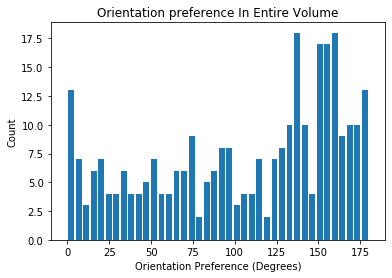

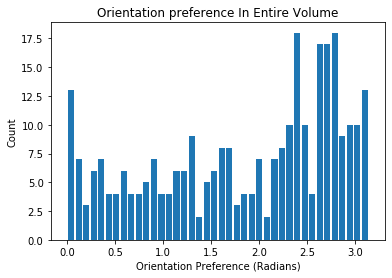

In [16]:
# set up bins for difference in prefered orientation
n_bins = 40
lower_bin_bound = 0
upper_bin_bound = np.pi
rad2deg = 180/np.pi
ori_edges = np.linspace(lower_bin_bound, upper_bin_bound, n_bins+1)
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
ori_labels = list(zip(oe[:-1], oe[1:]))
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 
#print("ori_centers = " + str(ori_centers))

bin_centers = ori_centers
ori_bin_edges=ori_edges
binned_ori_preferences = bin_centers[(np.digitize(orientation_preference, ori_bin_edges))-1]
raw_orientation_degrees = (np.array(orientation_preference)*rad2deg).astype("int")

"""
For the whole volume: Gets all the bins of the orientation and how many neurons in each group
"""

from collections import Counter
my_counter = Counter(binned_ori_preferences)
#print(my_counter)
binned_angles = np.array(list(my_counter.keys()))
binned_angles_histogram = np.array(list(my_counter.values()))
#print(binned_angles,binned_angles_histogram)

#plot as distribution of the orientations in the whole volume

plt.figure()
plt.title("Orientation preference In Entire Volume")
plt.bar(binned_angles,binned_angles_histogram,width=rad2deg*(ori_edges[1]-ori_edges[0])-1)
plt.xlabel("Orientation Preference (Degrees)")
plt.ylabel("Count")
plt.xlim([-10,190])
#plot as radians
plt.figure()
plt.title("Orientation preference In Entire Volume")
plt.bar(binned_angles/rad2deg,binned_angles_histogram,width=(ori_edges[1]-ori_edges[0]-0.1)*3)
plt.xlabel("Orientation Preference (Radians)")
plt.ylabel("Count")
plt.xlim([-10/rad2deg,190/rad2deg])



"""practices getting the circular statistics for orientation that only ranges from 0 - 180"""

binned_ori_preferences 
doubled_orientation_preference = np.array(orientation_preference)*2
np.max(doubled_orientation_preference),np.min(doubled_orientation_preference)

"""mean
pairwise_cdiff
cdiff: Difference between pairs
(angle + np.pi) % (2*np.pi) - np.pi
median
"""
print("Statistics for Entire Volume")
print("\n\n------Stats in Radians --------")
print("mean = " + str(pycs.mean(doubled_orientation_preference)/2))
print("variance = " + str(pycs.var(doubled_orientation_preference)/4))
print("std deviation = " + str(pycs.std(doubled_orientation_preference)/2))

print("\n\n------Stats in degrees --------")
print("mean = " + str(pycs.mean(doubled_orientation_preference)/2*rad2deg))
print("variance = " + str(pycs.var(doubled_orientation_preference)/4*rad2deg))
print("std deviation = " + str(pycs.std(doubled_orientation_preference)/2*rad2deg))

# Helper Functions for visualizing them in volume

In [69]:
def print_3D_visuals(soma_centers_list,c_values,target_neuron,target_val):
    if target_neuron != -1:
        target_neuron_flag = True
    else:
        target_neuron_flag = False
    #helps gets the ranges to use for limits
    total_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
    mins = np.min(total_list,axis=0) 
    maxs = np.max(total_list,axis=0)
    min_max_ranges = maxs - mins
    buffer_percentage = 0.1
    mins = np.min(total_list,axis=0) - buffer_percentage*min_max_ranges
    maxs = np.max(total_list,axis=0) + buffer_percentage*min_max_ranges
    
    if target_neuron_flag:
        #get the location of the target neuron
        loc = soma_cell_location_dict[target_neuron]["location"]
        target_x = loc[0]
        target_y = loc[1]
        target_z = loc[2]
        target_scatter_size = 20*4**2
    
    fig = plt.figure(figsize=(16,4))
    fig.tight_layout()
    ax = plt.subplot(1,3,1)
    ax.set_title("XY Projection")
    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,1], 
               c=c_values, 
               marker='o')
    if target_neuron_flag:
        ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_xlabel('x axis')
    ax.set_ylabel('Y axis')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')


    ax = plt.subplot(1,3,2)
    ax.set_title("XZ Projection")
    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')
    if target_neuron_flag:
        ax.scatter(target_x,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('x axis')
    ax.set_ylabel('z axis')
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[2],maxs[2]])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    
    ax = plt.subplot(1,3,3)
    ax.set_title("YZ Projection")
    sc = ax.scatter(soma_centers_list[:,1],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')
    if target_neuron_flag:
        ax.scatter(target_y,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('y axis')
    ax.set_ylabel('z axis')
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Ori Preference (radians)')
    ax.set_xlim([mins[1],maxs[1]])
    ax.set_ylim([mins[2],maxs[2]])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    #soma_cell_location_dict
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    import random


    fig = pyplot.figure()
    ax = Axes3D(fig)

    sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=c_values)
    if target_neuron_flag:
        ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_zlim([mins[2],maxs[2]])
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Ori Preference (radians)')
    pyplot.show()
    
def print_3D_visuals_raw_ids(new_group,target_neuron):
    
    ori_pref = [seg_id_to_orientation[a] for a in new_group]
    soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    soma_centers_list = soma_centers_list
    c_values = ori_pref
    target_val = target_neuron_orientation_preferene

    #helps gets the ranges to use for limits
    total_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
    mins = np.min(total_list,axis=0) 
    maxs = np.max(total_list,axis=0)
    min_max_ranges = maxs - mins
    buffer_percentage = 0.1
    mins = np.min(total_list,axis=0) - buffer_percentage*min_max_ranges
    maxs = np.max(total_list,axis=0) + buffer_percentage*min_max_ranges
    
    #get the location of the target neuron
    loc = soma_cell_location_dict[target_neuron]["location"]
    target_x = loc[0]
    target_y = loc[1]
    target_z = loc[2]
    target_scatter_size = 20*4**2
    
    fig = plt.figure(figsize=(16,4))
    fig.tight_layout()
    ax = plt.subplot(1,3,1)
    ax.set_title("XY Projection")
    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,1], 
               c=c_values, 
               marker='o')
    ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_xlabel('x axis')
    ax.set_ylabel('Y axis')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')


    ax = plt.subplot(1,3,2)
    ax.set_title("XZ Projection")
    sc = ax.scatter(soma_centers_list[:,0],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')

    ax.scatter(target_x,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('x axis')
    ax.set_ylabel('z axis')
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[2],maxs[2]])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    
    ax = plt.subplot(1,3,3)
    ax.set_title("YZ Projection")
    sc = ax.scatter(soma_centers_list[:,1],
               soma_centers_list[:,2], 
               c=c_values, 
               marker='o')
    ax.scatter(target_y,target_z,marker='X',s=target_scatter_size)
    ax.set_xlabel('y axis')
    ax.set_ylabel('z axis')
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Ori Preference (radians)')
    ax.set_xlim([mins[1],maxs[1]])
    ax.set_ylim([mins[2],maxs[2]])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    #soma_cell_location_dict
    from matplotlib import pyplot
    from mpl_toolkits.mplot3d import Axes3D
    import random


    fig = pyplot.figure()
    ax = Axes3D(fig)

    sc = ax.scatter(soma_centers_list[:,0], soma_centers_list[:,1], soma_centers_list[:,2],c=c_values)
    ax.scatter(target_x,target_y,marker='X',s=target_scatter_size)
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_xlim([mins[0],maxs[0]])
    ax.set_ylim([mins[1],maxs[1]])
    ax.set_zlim([mins[2],maxs[2]])
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Ori Preference (radians)')
    pyplot.show()

# Visualizing Entire Volume:

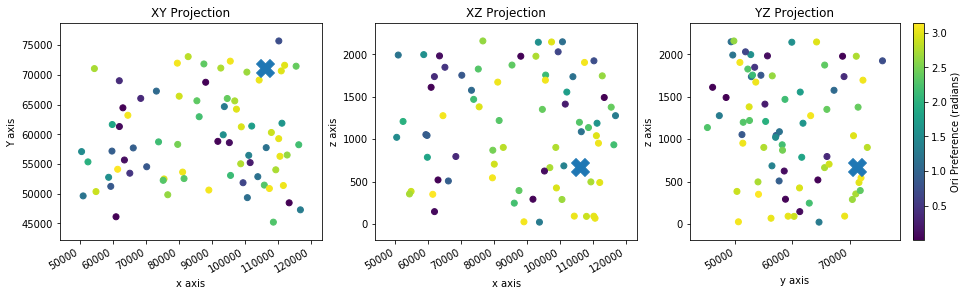

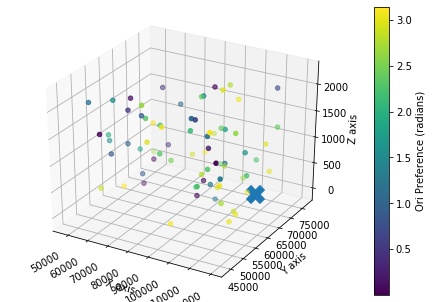

hello


In [19]:
target_neuron = 648518346341371119
total_neurons_list = soma_cell_location_dict.keys()
circular_radius = 10000

#graph all in comparison
new_group = soma_cell_location_dict.keys()
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
c_values = [seg_id_to_orientation[k] for k in new_group]

print_3D_visuals(soma_centers_list,c_values,target_neuron,target_neuron_orientation_preferene)
print("hello")

# Example of Visualizig a Subgroup



--------------Demonstrating Circular Subgroup Group ------------------
Radius = 1000 and total neurons in subgroup = 18


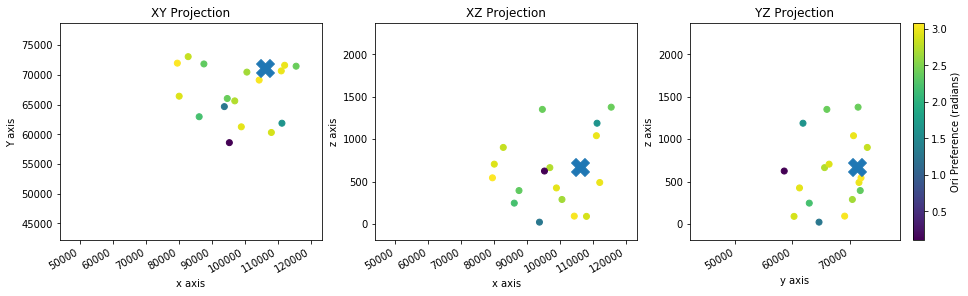

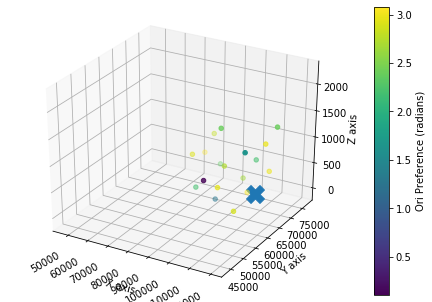



--------------Demonstrating for Z column ------------------
X,Y Width = 1200 and total neurons in subgroup = 15


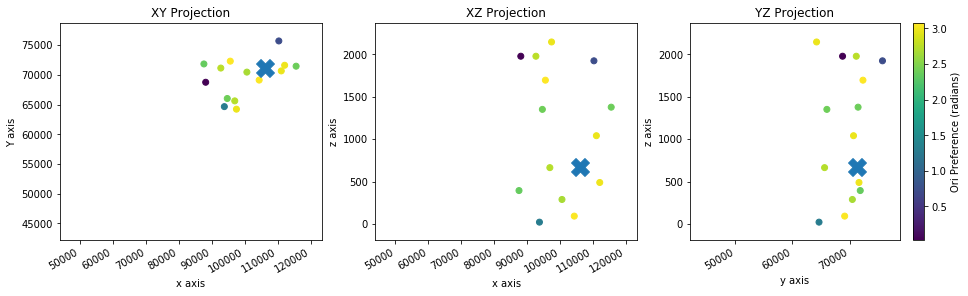

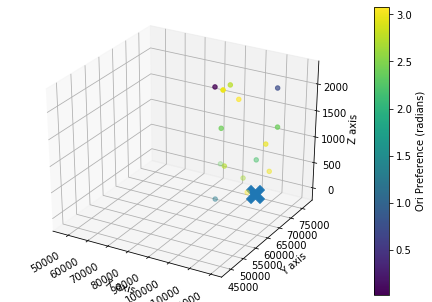



--------------Demonstrating for X column ------------------
Z,Y Width = 1200 and total neurons in subgroup = 14


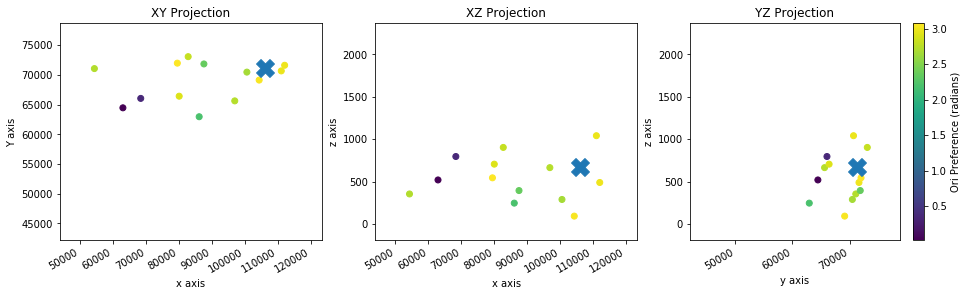

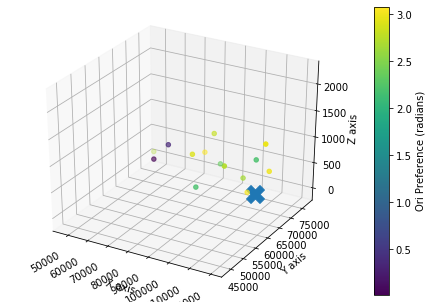



--------------Demonstrating for Y column ------------------
X,Z Width = 1200 and total neurons in subgroup = 21


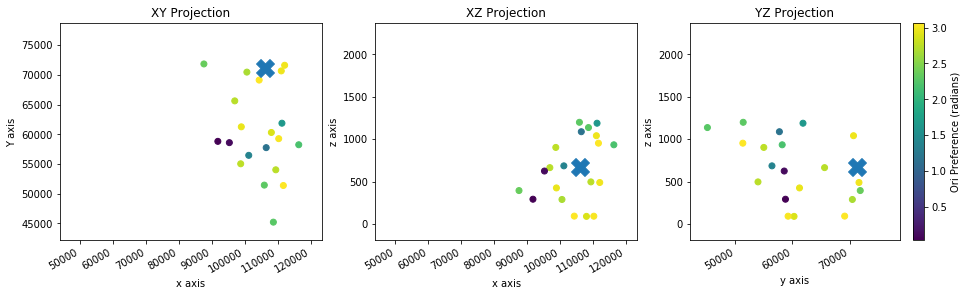

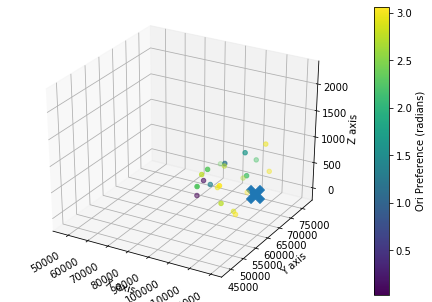

In [28]:
target_neuron = 648518346341371119
total_neurons_list = soma_cell_location_dict.keys()
circular_radius = 1000

circular_group = find_radius_subgroup(target_neuron,
                        total_neurons_list,
                        circular_radius,scaled=scale_flag)


box_height = box_width = 600
width_axis = "x_distance"
height_axis = "y_distance"
z_column_group =  find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width,
                         box_height,scaled=scale_flag)

print("\n\n--------------Demonstrating Circular Subgroup Group ------------------")
print(f"Radius = {circular_radius} and total neurons in subgroup = {len(circular_group)}")
# print(len(circular_group))
# print(len(z_column_group))

new_group = circular_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
np.min(soma_centers_list,axis=0),np.max(soma_centers_list,axis=0)

new_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
c_values = [seg_id_to_orientation[k] for k in new_group]

print_3D_visuals(soma_centers_list,c_values,target_neuron,target_neuron_orientation_preferene)


print("\n\n--------------Demonstrating for Z column ------------------")
print(f"X,Y Width = {box_width*2} and total neurons in subgroup = {len(z_column_group)}")

new_group = z_column_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])
np.min(soma_centers_list,axis=0),np.max(soma_centers_list,axis=0)

new_group
ori_pref = [seg_id_to_orientation[a] for a in new_group]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in new_group])
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]
c_values = [seg_id_to_orientation[k] for k in new_group]

print_3D_visuals(soma_centers_list,c_values,target_neuron,target_neuron_orientation_preferene)


print("\n\n--------------Demonstrating for X column ------------------")

box_height = box_width = 600
width_axis = "z_distance"
height_axis = "y_distance"
x_column_group =  find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width,
                         box_height,scaled=scale_flag)


print(f"Z,Y Width = {box_width*2} and total neurons in subgroup = {len(x_column_group)}")

print_3D_visuals_raw_ids(x_column_group,target_neuron)

print("\n\n--------------Demonstrating for Y column ------------------")

box_height = box_width = 600
width_axis = "z_distance"
height_axis = "x_distance"
y_column_group =  find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width,
                         box_height,scaled=scale_flag)


print(f"X,Z Width = {box_width*2} and total neurons in subgroup = {len(y_column_group)}")

print_3D_visuals_raw_ids(y_column_group,target_neuron)

# Functions to help with Graphing the Distributions: 

In [29]:
def bin_orientation_data(orientation_preference,
                         n_bins = 40,
                        lower_bin_bound = 0,
                         upper_bin_bound = np.pi):
    """
    Functions that will do binning of data
    Bases on the number of bins, lower bound and upper bound specified
    """
    
    rad2deg = 180/np.pi
    ori_edges = np.linspace(lower_bin_bound, upper_bin_bound, n_bins+1)
    oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
    ori_labels = list(zip(oe[:-1], oe[1:]))
    ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 

    bin_centers = ori_centers
    ori_bin_edges=ori_edges
    binned_ori_preferences = bin_centers[(np.digitize(orientation_preference, ori_bin_edges))-1]
    raw_orientation_degrees = (np.array(orientation_preference)*rad2deg).astype("int")
    
    from collections import Counter
    my_counter = Counter(binned_ori_preferences)
    #print(my_counter)
    binned_angles = np.array(list(my_counter.keys()))
    binned_angles_histogram = np.array(list(my_counter.values()))
    
    return binned_angles,binned_angles_histogram

def plot_circular_distribution_lite(theta,
                               radii,
                                    ax,
                                    n_bins,
                               width=-1,
                               bottom = 8):
    
    """
    will plot the circulation distribution given the 
    1) theta (x values)
    2) radii (y values)
    
    Other parameters passed: 
    0) axis to plot it on
    1) number of bins that could possibly be plotted
    
    optional
    1) Width of each of the bins (else it is calculated)
    2) bottom: The offset where the histogram starts
    
    
    
    
    """
    N = n_bins
    
    if width == -1:
        width = (2*np.pi) / N

    #ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.jet(r / 10.))
        bar.set_alpha(0.8)
    #ax.set_yticks([0,45,90,135,180])
    """
    ax.set_xticks(np.pi/180. * np.linspace(0,  180, 8, endpoint=False))
    ax.set_thetalim(0,np.pi)
    """
    ax.set_xticklabels(np.linspace(0,  180, 8, endpoint=False))
    #plt.show()

def graph_binned_orientation_data(binned_angles,
                                binned_angles_histogram,
                                  neuron_id,
                                  title,
                                  n_bins,
                                  global_binned_angles = [],
                                global_binned_angles_histogram= [],
                                 graphs_to_plot=[],
                                  figure_size = (20,20),
                                 circular_flag = True,
                                 target_neuron_orientation = -1,
                                 target_color="y"):
    """
    Will graph the linear/circular or both of the distribution of a certain group
    1) Will graph just the local group or global group alone if only
    "local" or "global" sent in graph to plot
    
    And then highlight the target neuron's orientation 
    """
    
    axis_label_size=20
    tick_label_size = 20
    title_size=30
    
    # if circular plots were also requested then adjust overall size
    if circular_flag:
        n_subplot = 2*len(graphs_to_plot)
    else:
        n_subplot = len(graphs_to_plot)
    
    width_size = 3
    #print("n_subplot = " + str(n_subplot))
    currnet_subplot = 1
    fig = plt.figure(figsize=(figure_size[0],figure_size[1]*len(graphs_to_plot)))
    fig.tight_layout()
    #fig.set_size_inches(20, 12)
    if "local" in graphs_to_plot:
        
        if circular_flag:
            ax = plt.subplot(n_subplot,2,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            if target_neuron_orientation != -1:
                plt.bar(target_neuron_orientation,[0.5],width=width_size,color=target_color)
#                 print(" target_neuron_orientation[0] = " + str( target_neuron_orientation[0]))
#                 print("binned_angles = " + str(binned_angles))
#                 angle_index = np.where(binned_angles == target_neuron_orientation[0])[0]
#                 if len(angle_index) == 0:
#                     target_neuron_height = 0.5
#                 else:
#                     target_neuron_height = binned_angles_histogram[angle_index]
#                 print("angle_index = " + str(angle_index))
#                 print("target_neuron_orientation/rad2deg = " + str(target_neuron_orientation/rad2deg))
#                 print("[target_neuron_height] =  " + str([target_neuron_height]))
#                 plt.bar(target_neuron_orientation/rad2deg,[target_neuron_height],width=width_size,color=target_color)
                #             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_linear",fontsize=title_size)
            ax.set_xlim([-10,190])
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            
            #graphing the circular graph
            ax = plt.subplot(n_subplot,2,currnet_subplot+1,polar=True)
            plot_circular_distribution_lite(binned_angles/rad2deg*2,
                                            binned_angles_histogram,
                                            ax,
                                           n_bins)
            
#             ax.set(
#                    title=title + "_circular",
#                    ylabel='Number of Neurons',
#                    xlabel='Degrees',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_circular",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
#             ax.set_xticklabels(ax.get_xticklabels(),fontsize=tick_label_size)
#             ax.set_yticklabels(ax.get_yticklabels(),fontsize=tick_label_size)
            
            #increment the current_subplot
            currnet_subplot += 2
        else:
            ax = plt.subplot(n_subplot,1,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            if target_neuron_orientation != -1:
                plt.bar(target_neuron_orientation,[0.5],width=width_size,color=target_color)
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_linear",fontsize=title_size)
            ax.set_xlim([-10,190])
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            #increment the current_subplot
            currnet_subplot += 1
    
    print("\n\n\n")
    if "global" in graphs_to_plot:
        binned_angles = global_binned_angles
        binned_angles_histogram =  global_binned_angles_histogram
        if circular_flag:
            ax = plt.subplot(n_subplot,2,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global_linear",fontsize=title_size)
            ax.set_xlim([-10,190])
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            
            #graphing the circular graph
            ax = plt.subplot(n_subplot,2,currnet_subplot+1,polar=True)
            plot_circular_distribution_lite(binned_angles/rad2deg*2,
                                            binned_angles_histogram,
                                            ax,n_bins)
            
#             ax.set(
#                    title=title + "_circular",
#                    ylabel='Number of Neurons',
#                    xlabel='Degrees',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global_circular",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
#             ax.set_xticklabels(ax.get_xticklabels(),fontsize=tick_label_size)
#             ax.set_yticklabels(ax.get_yticklabels(),fontsize=tick_label_size)
            
            #increment the current_subplot
            currnet_subplot += 2
        else:
            ax = plt.subplot(n_subplot,1,currnet_subplot)
            #graphing the linear graph
            plt.bar(binned_angles,binned_angles_histogram,width=width_size)
            
#             ax.set(
#                    title=title + "_linear",
#                    ylabel='Number of Neurons',
#                    xlabel='Radians',
#                     titlesize=20,
#                     labelsize=20)
            ax.set_title(title+"_global",fontsize=title_size)
            ax.set_xlabel("Degrees",fontsize=axis_label_size)
            ax.set_ylabel('Number of Neurons',fontsize=axis_label_size)
            ax.tick_params(axis="both",which="major",labelsize=tick_label_size)
            #increment the current_subplot
            currnet_subplot += 1
    left = 0.125
    right = 0.9
    bottom = 0.1
    top = 0.9
    wspace = 0.2
    hspace = 0.5
    fig.subplots_adjust(left=left,bottom=bottom,right=right,
                       top=top,wspace=wspace,hspace=hspace)
    plt.show()


binned_angles,binned_angles_histogram = bin_orientation_data(orientation_preference,
                                                         n_bins = 20,
                                                        lower_bin_bound = 0,
                                                         upper_bin_bound = np.pi)

# graph_binned_orientation_data(binned_angles,
#                                 binned_angles_histogram,
#                                   neuron_id=45,
#                               n_bins=20,
#                                   title="example_type",
#                               global_binned_angles = binned_angles,
#                                 global_binned_angles_histogram= binned_angles_histogram,
#                                  graphs_to_plot=["local","global"],
#                                  figure_size = (20,20),
#                                  circular_flag = True)s

-------- Showing Distributions of Y column Group -----------------
restricted_neuron_group = 20
global_neuron_group = 75


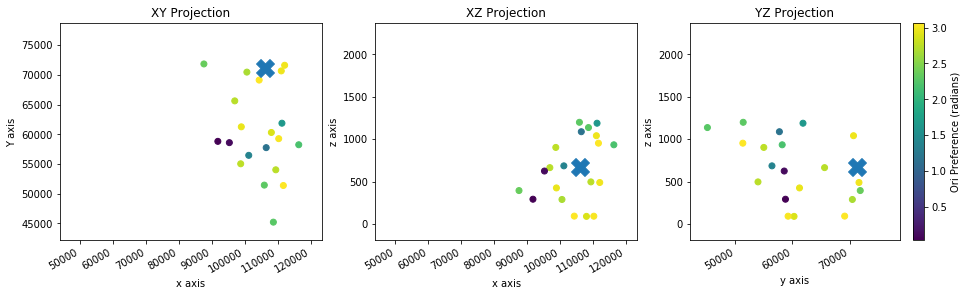

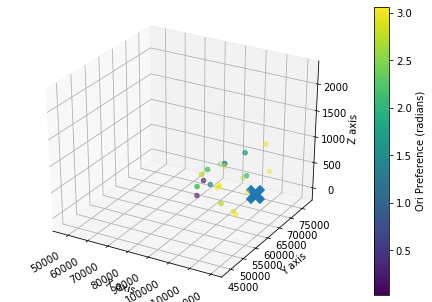

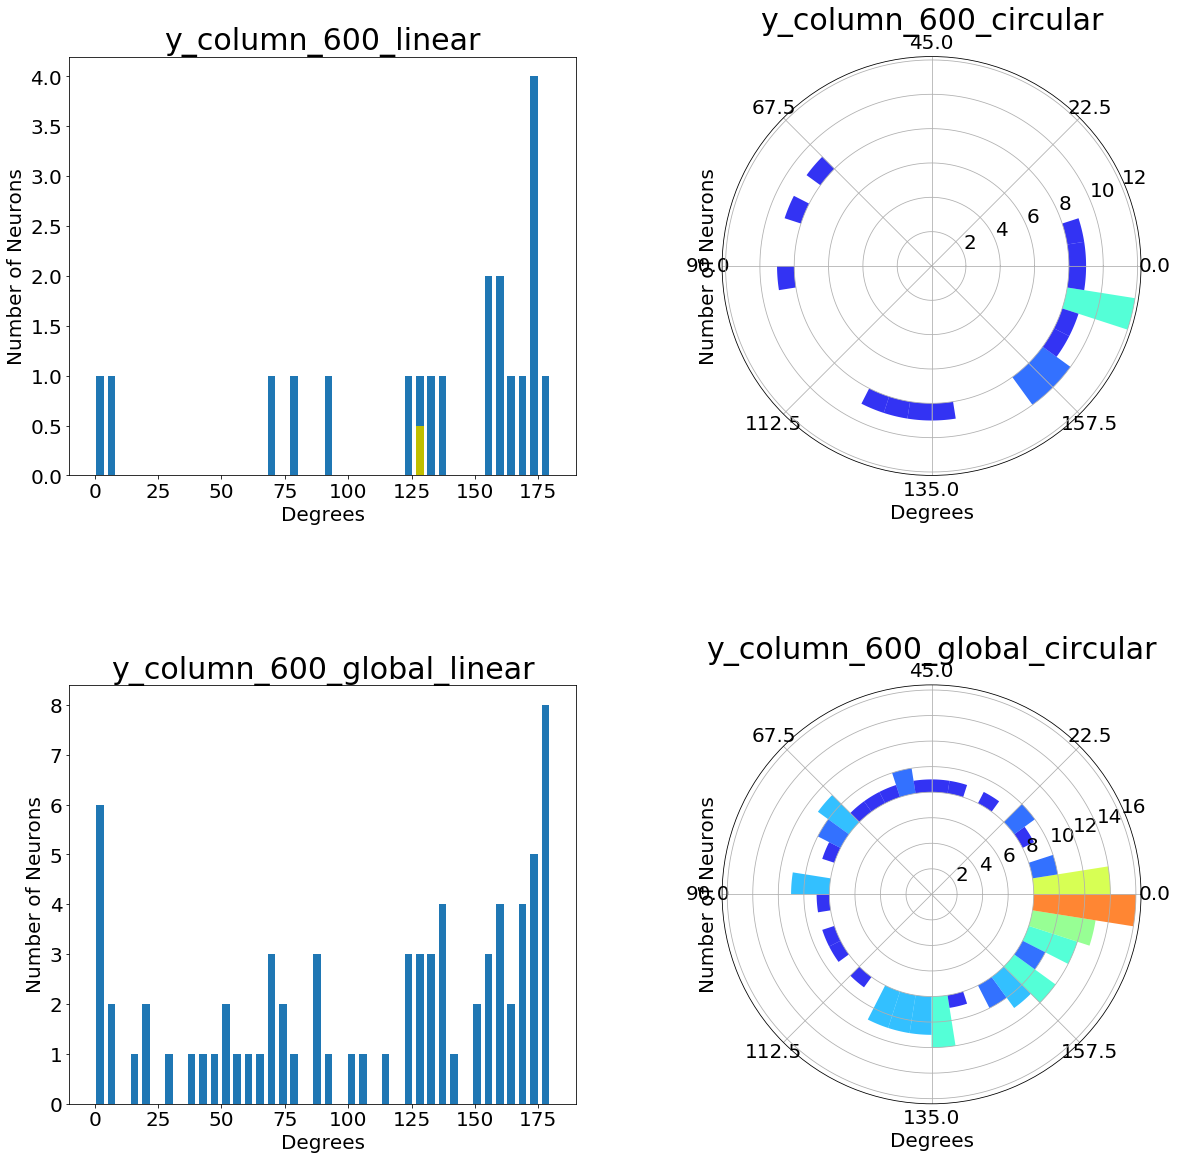

In [30]:
"""
Shows whole process of where start with a 

"""

#
target_neuron = 648518346341371119
target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]

total_neurons_list = list(soma_cell_location_dict.keys())
total_neurons_list.remove(target_neuron)


"""
Example of how to find neurons within x column
"""

box_height = box_width = 600

width_axis = "x_distance"
height_axis = "z_distance"

column_neurons =  find_column_subgroup(width_axis ,
                         height_axis,
                        target_neuron,
                        total_neurons_list,
                        box_width,
                         box_height,scaled=scale_flag)

# print("len(column_neurons) = " + str(len(column_neurons)))
# print(column_neurons)

"""
Get the orientation distribution and difference in orientation distributions for a target neuron and it's restricted neighbors

This example shows the circular_radius_neurons
"""

print("-------- Showing Distributions of Y column Group -----------------")
restricted_neuron_group = column_neurons
print("restricted_neuron_group = " + str(len(restricted_neuron_group)))
global_neuron_group = total_neurons_list = list(soma_cell_location_dict.keys())
print("global_neuron_group = " + str(len(global_neuron_group)))
print_3D_visuals_raw_ids(restricted_neuron_group,target_neuron)


#get the orientations of these groups
restricted_neuron_group_orientations = [seg_id_to_orientation[k] for k in restricted_neuron_group] #NOT INCLUDE TARGET NEURON

global_neuron_group_orientations = [seg_id_to_orientation[k] for k in global_neuron_group] # DOES INCLUDE TARGET NEURON



current_n_bins = 40
current_lower_bin_bound = 0
current_upper_bin_bound = np.pi

binned_angles,binned_angles_histogram = bin_orientation_data(restricted_neuron_group_orientations,
                                                         n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)

global_binned_angles,global_binned_angles_histogram = bin_orientation_data(global_neuron_group_orientations,
                                                         n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)

interest_binned_angles,interest_binned_angles_histogram = bin_orientation_data([target_neuron_orientation_preferene],
                                                        n_bins = current_n_bins,
                                                        lower_bin_bound = current_lower_bin_bound,
                                                         upper_bin_bound = current_upper_bin_bound)



#print wh

graph_binned_orientation_data(binned_angles,
                                binned_angles_histogram,
                                  neuron_id=target_neuron,
                                  title="y_column_"+str(box_width),
                              n_bins=current_n_bins,
                              global_binned_angles = global_binned_angles,
                                global_binned_angles_histogram= global_binned_angles_histogram,
                                 graphs_to_plot=["local","global"],
                                 figure_size = (20,20),
                                 circular_flag = True,
                                 target_neuron_orientation = interest_binned_angles)




In [40]:
# Picking the widths and radius to use:
# test 2 (more strict to try and keep around 10 neurons for at least 90 %)
y_width = y_height = 600
z_width = z_height = 600
x_width = x_height = 600
circular_radius = 1000

# Demo: Analyzing One subgroup and comparing it to the random shuffles

******* STARTING ON NEW NEURON *******************
restricted_neuron_group_mse for group y_column_subgroup = 0.4851035262378781
probability_less_than for group y_column_subgroup = 0.001


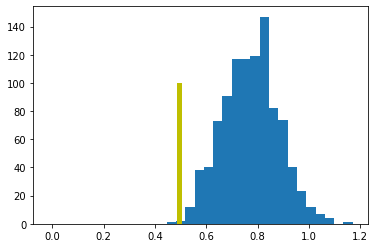

restricted_neuron_group_mse for group z_column_subgroup = 0.5867816690959013
probability_less_than for group z_column_subgroup = 0.175


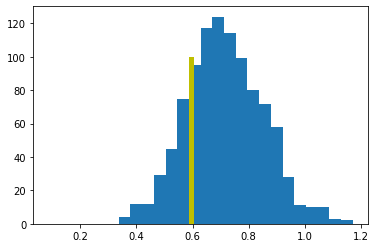

restricted_neuron_group_mse for group x_column_subgroup = 0.5478926456156041
probability_less_than for group x_column_subgroup = 0.123


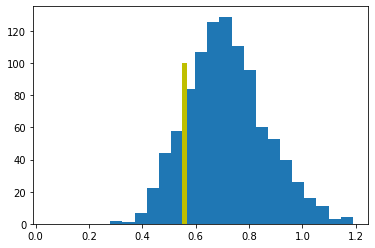

restricted_neuron_group_mse for group circular_subgroup = 0.44638996663118974
probability_less_than for group circular_subgroup = 0.002


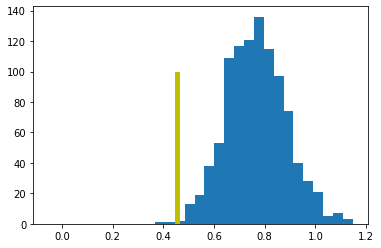

Total time for neurons = 1.3220386505126953


In [41]:
import time
import random
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()
#target_neuron = 648518346341371119
start_time = time.time()

for i,target_neuron in enumerate(soma_cell_location_dict.keys()):
    print("******* STARTING ON NEW NEURON *******************")
    
    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """
    

    
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height,scaled=scale_flag)
    #y_column_orientation_preferences = [seg_id_to_orientation[k] for k in y_column_subgroup]
    #y_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in y_column_subgroup])
    
    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height,scaled=scale_flag)
    #z_column_orientation_preferences = [seg_id_to_orientation[k] for k in z_column_subgroup]
    #z_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in z_column_subgroup])

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height,scaled=scale_flag)
    #x_column_orientation_preferences = [seg_id_to_orientation[k] for k in x_column_subgroup]
    #x_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in x_column_subgroup])
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)
    
    #visualize the groups to make sure correct:
    #target_cell_location = soma_cell_location_dict[target_neuron]["location"]
    
    print_subgroups = False
    if print_subgroups:
        print("\n\n------------- X Column Subgroup -------------")
        print_3D_visuals_raw_ids(x_column_subgroup,target_neuron)
        print("\n\n------------- Y Column Subgroup -------------")
        print_3D_visuals_raw_ids(y_column_subgroup,target_neuron)
        print("\n\n------------- Z Column Subgroup -------------")
        print_3D_visuals_raw_ids(z_column_subgroup,target_neuron)
        print("\n\n------------- Sphere Subgroup -------------")
        print_3D_visuals_raw_ids(circular_subgroup,target_neuron)
        
    # The graphhing looks a little off because the Z axis is smaller than the rest and throws things off
    
#     radius_column_orientation_preferences = [seg_id_to_orientation[k] for k in circular_subgroup]
#     radius_soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in circular_subgroup])
    
#     print_3D_visuals(radius_soma_centers_list,radius_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(x_soma_centers_list,x_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(y_soma_centers_list,y_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)
#     print_3D_visuals(z_soma_centers_list,z_column_orientation_preferences,target_neuron,target_neuron_orientation_preferene)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        (k != target_neuron))]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
        
        #plot the distribution
        print(f"restricted_neuron_group_mse for group {subgroup_name} = " + str(restricted_neuron_group_mse))
        print(f"probability_less_than for group {subgroup_name} = " + str(probability_less_than))
        plt.figure()
        plt.hist(random_shuffles_mse,bins=20)
        plt.hist([restricted_neuron_group_mse]*100,color="y",width=0.02)
        plt.show()
    break
print(f"Total time for neurons = " + str(time.time() - start_time))



Total time for neurons = 25.268024921417236


Text(0.5, 1.0, 'Total probability distributions\nx_width = 600, x_height = 600\ny_width = 600, y_height = 600\nz_width = 600, z_height = 600\ncircular_radius = 1000\nmean subgroup number = 17.947\nstd dev subgroup number = 5.88\n Mean probability = 0.45')

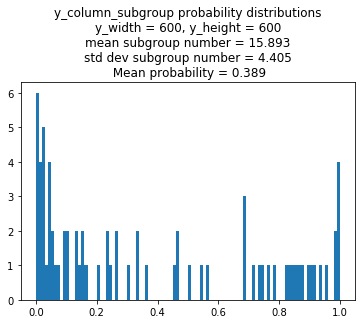

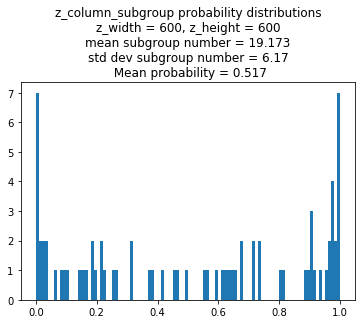

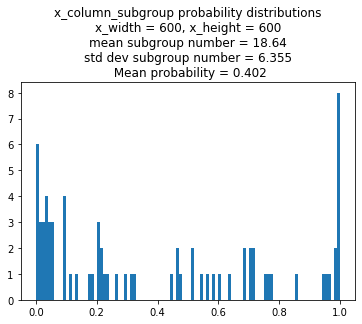

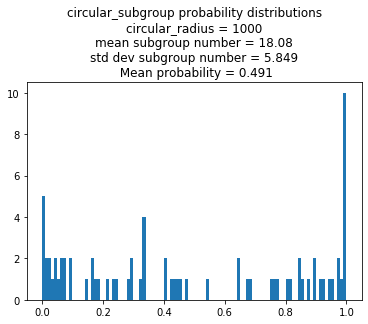

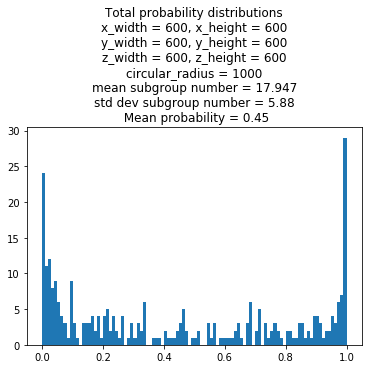

In [42]:
"""Steps for analysis: For each neuron
    1) Get the subgroup (from columns or spheres), can adjust for the same number of neurons or same distance
    2) Calculate the average mse of the orientations of the subgroup from the neuron of interest (aka get the variance)
    3) Calculate the same thing as step 2 but with a random shuffle of neurons from outside the volume (repeat for lots of shuffles so get the distribution)
    4) Compare Step 2 and compute the probability of getting that from the distribution gotten in step 3
    Repeat 1- 4 for all neurons

Look at what the average probability is for all neurons and see if there is instane wher
    
    
mse from the columns

keep the column heights and sphere volume the same"""
import time
import random
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()
#target_neuron = 648518346341371119
start_time = time.time()
for target_neuron in soma_cell_location_dict.keys():
    

    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """

    # test 1
    y_width = y_height = 600
    z_width = z_height = 600
    x_width = x_height = 600
    circular_radius = 1000
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height,scaled=scale_flag)

    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height,scaled=scale_flag)

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height,scaled=scale_flag)

    
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        k != target_neuron)]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
print(f"Total time for neurons = " + str(time.time() - start_time))


x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
sphere_parameter_string = f"circular_radius = {circular_radius}"


whole_parameters_string = "\n"+x_parameter_string+ \
                            "\n"+y_parameter_string+ \
                            "\n"+z_parameter_string+ \
                            "\n"+sphere_parameter_string

parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                    sphere_parameter_string]

whole_parameters_string

#get all of the probabilities for each group

column_sphere_names = subgroups_list.keys()
total_probabilities = []
total_group_number = []
column_sphere_subgroup_number = dict()
column_sphere_probabilities = dict()
for volume_name,param in zip(column_sphere_names,parameter_strings):
    column_sphere_probabilities[volume_name] = []
    column_sphere_subgroup_number[volume_name] = []
    for a in mse_data.keys():
            column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
            column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
    plt.figure()
    plt.hist(column_sphere_probabilities[volume_name],bins=100)
    mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
    std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
    plt.title(volume_name  + " probability distributions\n" + param 
                           + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                           + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                            + "\n Mean probability = " + str(np.round(np.mean(column_sphere_probabilities[volume_name]),3)))
    total_group_number += column_sphere_subgroup_number[volume_name]
    total_probabilities += column_sphere_probabilities[volume_name]
    
    
mean_group_number = np.mean(total_group_number)
std_dev_group_number = np.std(total_group_number)

plt.figure()
plt.hist(total_probabilities,bins=100)
plt.title("Total probability distributions" + whole_parameters_string
         + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
         + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
         + "\n Mean probability = " + str(np.round(np.mean(total_probabilities),3)))

# Do same Probability Analysis but for only neurons with Certain Orientation Preference

In [50]:
def run_orientation_preference_window_probability_analysis(window_size_radians,n_window_samples):
    mse_radian_subgroup = dict()

    window_radians_stepsize = np.pi/n_window_samples

    total_center_radians = np.linspace(0,np.pi,n_window_samples)

    #-------------------starting loop through all middle orientations-----------------------#
    for middle_orientation in total_center_radians:
        mse_radian_subgroup[middle_orientation] = dict()

        #print(f"Radians range = {(middle_orientation - window_size_radians,middle_orientation + window_size_radians)}")

        #get the orientation differences of all
        target_neurons_to_iterate_through = [k for k in soma_cell_location_dict.keys() if 
                                             np.abs(pycs.cdiff(seg_id_to_orientation[k]*2,middle_orientation*2)/2) < window_size_radians]

        #print("len(target_neurons_to_iterate_through) = " + str(len(target_neurons_to_iterate_through)))
        mse_radian_subgroup[middle_orientation]["neuron_number"] = len(target_neurons_to_iterate_through)

        #checking that correctly getting the subgroup
        orientations_neurons_to_iterate_through = [seg_id_to_orientation[k] for k in target_neurons_to_iterate_through]
        x = plt.hist(orientations_neurons_to_iterate_through,bins=20)
        plt.xlim([0,np.pi])
        #print((min(x[1]),max(x[1])))


        plotting = False

        mse_data = dict()
        #target_neuron = 648518346341371119
        start_time = time.time()

        for target_neuron in target_neurons_to_iterate_through:


            mse_data[target_neuron] = dict()

            target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


            target_scaled = target_neuron_orientation_preferene*2
            """
            Example of how to find neurons within a certain radius
            """
            total_neurons_list = list(soma_cell_location_dict.keys())
            total_neurons_list.remove(target_neuron)

            """
            Example of how to find neurons within x column
            """


            width_axis = "x_distance"; height_axis = "z_distance"
            y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height,scaled=scale_flag)


            width_axis = "x_distance"; height_axis = "y_distance"
            z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height,scaled=scale_flag)


            width_axis = "y_distance"; height_axis = "z_distance"
            x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height,scaled=scale_flag)


            circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)


            subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                                 z_column_subgroup=z_column_subgroup,
                                 x_column_subgroup=x_column_subgroup,
                                 circular_subgroup=circular_subgroup)

            n_random_shuffles = 1000



            for subgroup_name,restricted_neuron_group in subgroups_list.items():
                #get the mse of that subgroup
                restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                                      target_scaled)
                outside_neurons = [k for k in total_neurons_list if 
                               ((k not in restricted_neuron_group) and 
                                k != target_neuron)]
        #         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
        #         print("len(outside_neurons) = " + str(len(outside_neurons)))

                random_shuffles_mse = []
                for i in range(0,n_random_shuffles):
                    #get a random list from outside the subgroup
                    if len(restricted_neuron_group) < len(outside_neurons):
                        outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
                    else:
                        if i == 1:
                            print("not using sampling")
                        outside_neurons_rand = outside_neurons

                    if len(restricted_neuron_group) < len(outside_neurons_rand):
                        print("RESTRICTED GROUP NUMBER IS LESS")
                    random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                                      target_scaled))

                #save the random shuffles
                mse_data[target_neuron][subgroup_name] = dict() 
                mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
                mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
                mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)

                probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
                mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
        print(f"Total time for neurons = " + str(time.time() - start_time))


        x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
        y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
        z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
        sphere_parameter_string = f"circular_radius = {circular_radius}"


        whole_parameters_string = "\n"+x_parameter_string+ \
                                    "\n"+y_parameter_string+ \
                                    "\n"+z_parameter_string+ \
                                    "\n"+sphere_parameter_string

        parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                            sphere_parameter_string]

        whole_parameters_string

        #get all of the probabilities for each group

        column_sphere_names = subgroups_list.keys()
        total_probabilities = []
        total_group_number = []
        column_sphere_subgroup_number = dict()
        column_sphere_probabilities = dict()
        for volume_name,param in zip(column_sphere_names,parameter_strings):
            column_sphere_probabilities[volume_name] = []
            column_sphere_subgroup_number[volume_name] = []
            for a in mse_data.keys():
                    column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
                    column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
            mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
            std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
            mean_probability = np.mean(column_sphere_probabilities[volume_name])
            if plotting:
                plt.figure()
                plt.hist(column_sphere_probabilities[volume_name],bins=100)

                plt.title(volume_name  + " probability distributions\n" + param 
                                       + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                                       + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                                        + "\n Mean probability = " + str(np.round(mean_probability,3)))

            #store the mean probability, subgroup number and std deviation in the largest dictionary so 
            # can compare as iterate over the radians
            mse_radian_subgroup[middle_orientation][volume_name] = dict(mean_group_number=mean_group_number,
                                                                       std_dev_group_number=std_dev_group_number,
                                                                       mean_probability=mean_probability)


            total_group_number += column_sphere_subgroup_number[volume_name]
            total_probabilities += column_sphere_probabilities[volume_name]


        mean_group_number = np.mean(total_group_number)
        std_dev_group_number = np.std(total_group_number)
        mean_probability = np.mean(total_probabilities)

        mse_radian_subgroup[middle_orientation]["total"] = dict(mean_group_number=mean_group_number,
                                                                       std_dev_group_number=std_dev_group_number,
                                                                       mean_probability=mean_probability)
        if plotting:
            plt.figure()
            plt.hist(total_probabilities,bins=100)
            plt.title("Total probability distributions" + whole_parameters_string
                     + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                     + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                     + "\n Mean probability = " + str(np.round(mean_probability,3)))
    """
    Graphs want to do 
    1) The mean probability of each group vs. center
    2) The mean group number of each group vs. center
    3) The std dev group number of each group vs. center
    4) Number neurons that were tested in each radian group vs. center

    """

    x = list(mse_radian_subgroup.keys())
    column_type = list(mse_radian_subgroup[list(x)[0]].keys())
    if "neuron_number" in column_type:
        column_type.remove("neuron_number")

    #get the data for each column type
    probability_data = dict()
    std_dev_group_data = dict()
    mean_group_data = dict()
    for t in column_type:
        probability_data[t] = [v[t]["mean_probability"] for k,v in mse_radian_subgroup.items()]
        std_dev_group_data[t] = [v[t]["mean_group_number"] for k,v in mse_radian_subgroup.items()]
        mean_group_data[t] = [v[t]["std_dev_group_number"] for k,v in mse_radian_subgroup.items()]

    #get the neuron number for each radian group
    neuron_number_data = [mse_radian_subgroup[k]["neuron_number"] for k in mse_radian_subgroup.keys()]

    window_size_radians_rounded = np.round(window_size_radians,3)
    plt.figure()
    plt.title(" Mean Probabilty vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
    for t,y in probability_data.items():
        plt.plot(x,y,label=t)
    plt.legend()
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

    fig = plt.figure()

    plt.title(" Mean group number vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
    for t,y in mean_group_data.items():
        plt.plot(x,y,label=t)
    plt.legend()
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

    plt.figure()
    plt.title(" Std dev group number vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
    for t,y in std_dev_group_data.items():
        plt.plot(x,y,label=t)
    plt.legend()
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

    plt.figure()
    plt.title(" n_neurons in radian range vs. Radian center with window size +/- " + str(window_size_radians_rounded) + " radians")
    plt.plot(x,neuron_number_data)

/n/n********** Running with Window Size = 0.39269908169872414 ****************
Total time for neurons = 10.701504230499268
Total time for neurons = 9.426966905593872
Total time for neurons = 8.25020170211792
Total time for neurons = 5.840085983276367
Total time for neurons = 2.815007209777832
Total time for neurons = 2.753765106201172
Total time for neurons = 2.7345550060272217
Total time for neurons = 3.026031255722046
Total time for neurons = 3.6522023677825928
Total time for neurons = 4.026714086532593
Total time for neurons = 4.045973539352417
Total time for neurons = 4.71765923500061
Total time for neurons = 4.403301954269409
Total time for neurons = 4.039155721664429
Total time for neurons = 4.065218925476074
Total time for neurons = 3.323242664337158
Total time for neurons = 2.749601364135742
Total time for neurons = 3.910271644592285
Total time for neurons = 4.816981315612793
Total time for neurons = 5.231257438659668
Total time for neurons = 5.212860584259033
Total time for ne

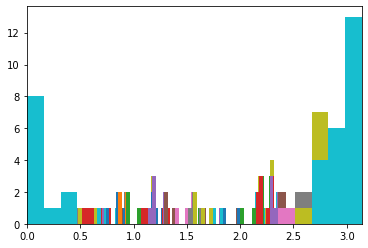

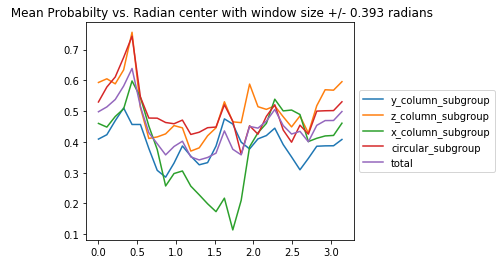

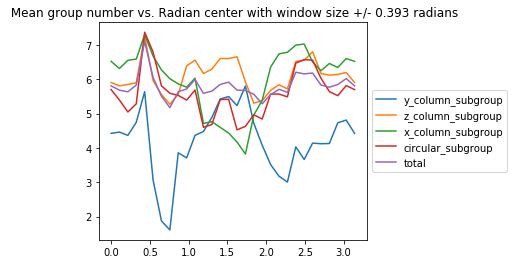

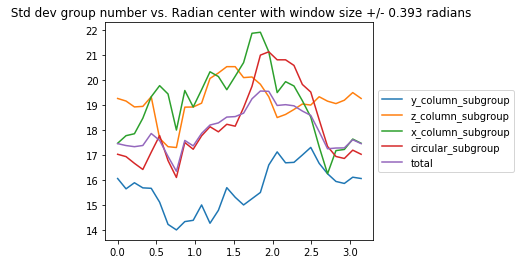

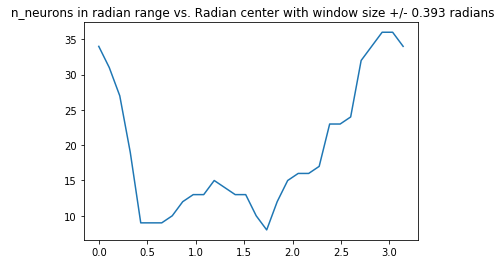

In [51]:
mse_radian_subgroup = dict()
window_size_degrees = 180/16/2
window_size_radians = window_size_degrees/rad2deg*4

#how the radians will move when graphing them
n_window_samples = 30

current_window_size = window_size_radians
print(f"/n/n********** Running with Window Size = {current_window_size} ****************")
run_orientation_preference_window_probability_analysis(current_window_size,n_window_samples)

# Trying Different Window Sizes: 

/n/n********** Running with Window Size = 0.19634954084936207 ****************
Total time for neurons = 7.4623613357543945
Total time for neurons = 5.5587053298950195
Total time for neurons = 2.847504138946533
Total time for neurons = 1.2589576244354248
Total time for neurons = 0.9036602973937988
Total time for neurons = 1.220829963684082
Total time for neurons = 0.9470140933990479
Total time for neurons = 1.8667938709259033
Total time for neurons = 1.5421206951141357
Total time for neurons = 1.862192153930664
Total time for neurons = 2.5263471603393555
Total time for neurons = 2.160719156265259
Total time for neurons = 2.222395420074463
Total time for neurons = 1.891556978225708
Total time for neurons = 1.6282992362976074
Total time for neurons = 1.797118902206421
Total time for neurons = 1.710737943649292
Total time for neurons = 0.9891719818115234
Total time for neurons = 0.9884593486785889
Total time for neurons = 2.1480824947357178
Total time for neurons = 4.129787921905518
Total 

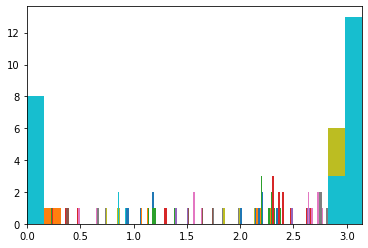

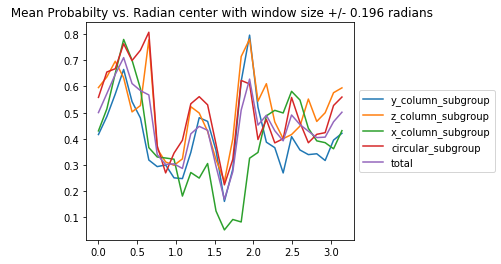

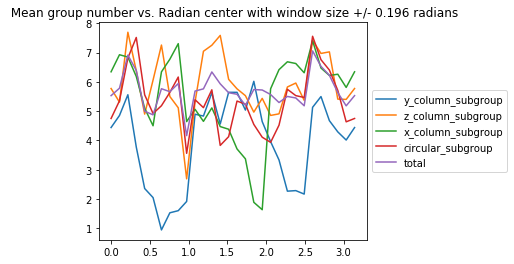

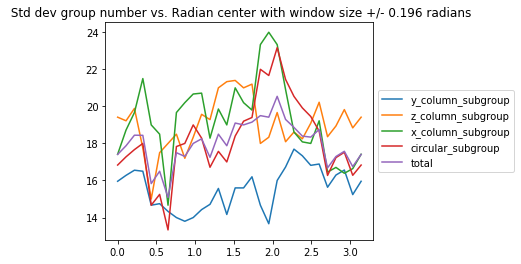

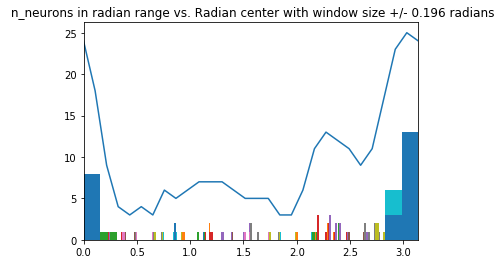

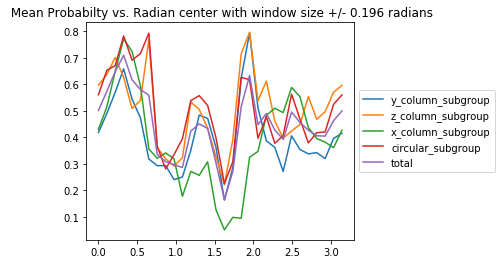

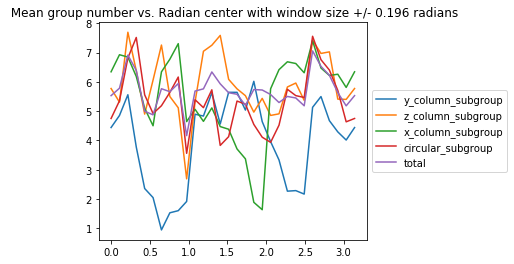

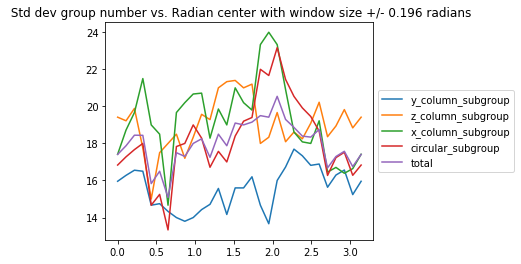

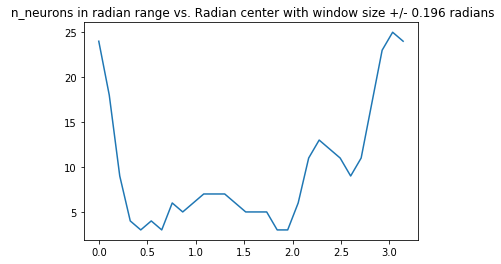

In [52]:

current_window_size = window_size_radians/2
print(f"/n/n********** Running with Window Size = {current_window_size} ****************")
run_orientation_preference_window_probability_analysis(current_window_size,n_window_samples)
current_window_size = window_size_radians*2
print(f"/n/n********** Running with Window Size = {current_window_size} ****************")
run_orientation_preference_window_probability_analysis(window_size_radians/2,n_window_samples)

# Iterating through different Scalings and Seeing how that changes:

In [75]:
# Picking the widths and radius to use:
# test 2 (more strict to try and keep around 10 neurons for at least 90 %)
y_saved = y_width 
z_saved = z_width 
x_saved = x_width 
circular_radius_saved = circular_radius 

y_saved = 600
z_saved = 600
x_saved = 600
circular_radius_saved = 1000







  0%|          | 0/20 [00:00<?, ?it/s]

***** Current Scale = 0.25*******


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in greater






  5%|▌         | 1/20 [00:26<08:22, 26.46s/it]

Total time for neurons = 26.37983989715576
***** Current Scale = 0.39473684210526316*******








 10%|█         | 2/20 [00:55<08:11, 27.28s/it]

Total time for neurons = 29.164114713668823
***** Current Scale = 0.5394736842105263*******








 15%|█▌        | 3/20 [01:28<08:11, 28.92s/it]

Total time for neurons = 32.697497844696045
***** Current Scale = 0.6842105263157895*******








 20%|██        | 4/20 [02:04<08:16, 31.04s/it]

Total time for neurons = 35.91942310333252
***** Current Scale = 0.8289473684210527*******








 25%|██▌       | 5/20 [02:44<08:27, 33.82s/it]

Total time for neurons = 40.27652406692505
***** Current Scale = 0.9736842105263158*******








 30%|███       | 6/20 [03:20<08:01, 34.38s/it]

Total time for neurons = 35.613455295562744
***** Current Scale = 1.118421052631579*******








 35%|███▌      | 7/20 [04:00<07:49, 36.08s/it]

Total time for neurons = 40.00014114379883
***** Current Scale = 1.263157894736842*******
not using sampling








 40%|████      | 8/20 [04:40<07:26, 37.22s/it]

Total time for neurons = 39.84901523590088
***** Current Scale = 1.4078947368421053*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling








 45%|████▌     | 9/20 [05:19<06:54, 37.73s/it]

Total time for neurons = 38.873170614242554
***** Current Scale = 1.5526315789473686*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling








 50%|█████     | 10/20 [05:59<06:26, 38.63s/it]

Total time for neurons = 40.70008683204651
***** Current Scale = 1.6973684210526316*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling








 55%|█████▌    | 11/20 [06:42<05:58, 39.79s/it]

Total time for neurons = 42.421661615371704
***** Current Scale = 1.8421052631578947*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampl







 60%|██████    | 12/20 [07:21<05:16, 39.59s/it]

Total time for neurons = 39.090580463409424
***** Current Scale = 1.986842105263158*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampli







 65%|██████▌   | 13/20 [08:01<04:37, 39.61s/it]

Total time for neurons = 39.58990716934204
***** Current Scale = 2.1315789473684212*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampli







 70%|███████   | 14/20 [08:41<03:58, 39.78s/it]

Total time for neurons = 40.132585525512695
***** Current Scale = 2.276315789473684*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampli







 75%|███████▌  | 15/20 [09:25<03:25, 41.11s/it]

Total time for neurons = 44.1873414516449
***** Current Scale = 2.4210526315789473*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using samplin







 80%|████████  | 16/20 [10:07<02:45, 41.29s/it]

Total time for neurons = 41.65376400947571
***** Current Scale = 2.5657894736842106*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampli







 85%|████████▌ | 17/20 [10:50<02:05, 41.86s/it]

not using sampling
Total time for neurons = 43.14315414428711
***** Current Scale = 2.710526315789474*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using samplin







 90%|█████████ | 18/20 [11:26<01:19, 39.96s/it]

not using sampling
Total time for neurons = 35.45199203491211
***** Current Scale = 2.855263157894737*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using samplin







 95%|█████████▌| 19/20 [11:52<00:35, 35.99s/it]

not using sampling
Total time for neurons = 26.694721221923828
***** Current Scale = 3.0*******
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using sampling
not using s







100%|██████████| 20/20 [12:18<00:00, 36.93s/it]

not using sampling
Total time for neurons = 25.832646369934082


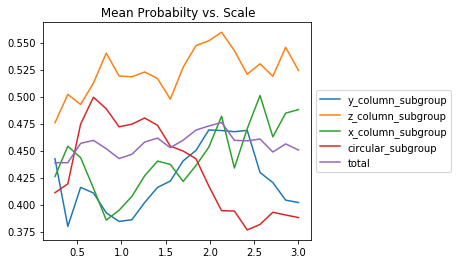

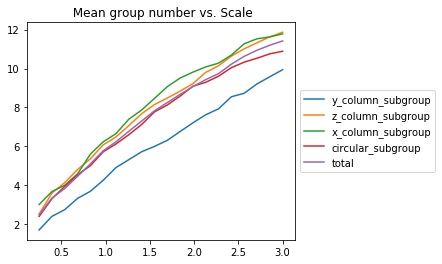

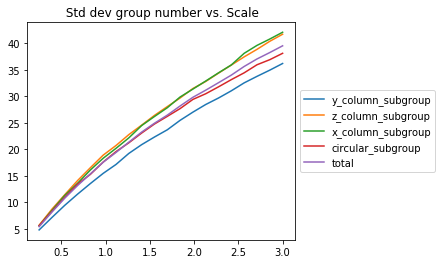

In [76]:
# Iterating over differing the scale and seeing how that changes:
mse_scale_subgroup = dict()
n_window_samples = 20
total_scalings = np.linspace(0.25,3,n_window_samples)

#-------------------starting loop through all middle orientations-----------------------#
for scale_factor in tqdm(total_scalings):
    print(f"***** Current Scale = {scale_factor}*******")
    mse_scale_subgroup[scale_factor] = dict()


    plotting = False

    mse_data = dict()
    #target_neuron = 648518346341371119
    start_time = time.time()

    for target_neuron in soma_cell_location_dict.keys():


        mse_data[target_neuron] = dict()

        target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


        target_scaled = target_neuron_orientation_preferene*2
        """
        Example of how to find neurons within a certain radius
        """
        total_neurons_list = list(soma_cell_location_dict.keys())
        total_neurons_list.remove(target_neuron)

        """
        Example of how to find neurons within x column
        """

        
        circular_radius_scaled = (scale_factor**(1/3))*circular_radius_saved
        y_new_width_scaled = (scale_factor**(1/2))*y_saved
        z_new_width_scaled = (scale_factor**(1/2))*z_saved
        x_new_width_scaled = (scale_factor**(1/2))*x_saved

#         print("\n New widths and radius SCALED by factor of " + str(scale_factor))
#         print("y_new_width_scaled = " + str(y_new_width_scaled))
#         print("z_new_width_scaled = " + str(z_new_width_scaled))
#         print("x_new_width_scaled = " + str(x_new_width_scaled))
#         print("circular_radius_scaled = " + str(circular_radius_scaled))
        
        y_width = y_height = y_new_width_scaled
        z_width = z_height = z_new_width_scaled
        x_width = x_height = x_new_width_scaled
        circular_radius = circular_radius_scaled
        
        #print(y_width,z_width,x_width,circular_radius)
        

        width_axis = "x_distance"; height_axis = "z_distance"
        y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height,scaled=scale_flag)


        width_axis = "x_distance"; height_axis = "y_distance"
        z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height,scaled=scale_flag)


        width_axis = "y_distance"; height_axis = "z_distance"
        x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height,scaled=scale_flag)


        circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)


        subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                             z_column_subgroup=z_column_subgroup,
                             x_column_subgroup=x_column_subgroup,
                             circular_subgroup=circular_subgroup)

        n_random_shuffles = 1000



        for subgroup_name,restricted_neuron_group in subgroups_list.items():
            #get the mse of that subgroup
            restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                                  target_scaled)
            outside_neurons = [k for k in total_neurons_list if 
                           ((k not in restricted_neuron_group) and 
                            k != target_neuron)]
    #         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
    #         print("len(outside_neurons) = " + str(len(outside_neurons)))

            random_shuffles_mse = []
            for i in range(0,n_random_shuffles):
                #get a random list from outside the subgroup
                if len(restricted_neuron_group) < len(outside_neurons):
                    outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
                else:
                    if i == 1:
                        print("not using sampling")
                    outside_neurons_rand = outside_neurons

                if len(restricted_neuron_group) < len(outside_neurons_rand):
                    print("RESTRICTED GROUP NUMBER IS LESS")
                random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                                  target_scaled))

            #save the random shuffles
            mse_data[target_neuron][subgroup_name] = dict() 
            mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
            mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
            mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)

            probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
            mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
    print(f"Total time for neurons = " + str(time.time() - start_time))


    x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
    y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
    z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
    sphere_parameter_string = f"circular_radius = {circular_radius}"


    whole_parameters_string = "\n"+x_parameter_string+ \
                                "\n"+y_parameter_string+ \
                                "\n"+z_parameter_string+ \
                                "\n"+sphere_parameter_string

    parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                        sphere_parameter_string]

    whole_parameters_string

    #get all of the probabilities for each group

    column_sphere_names = subgroups_list.keys()
    total_probabilities = []
    total_group_number = []
    column_sphere_subgroup_number = dict()
    column_sphere_probabilities = dict()
    for volume_name,param in zip(column_sphere_names,parameter_strings):
        column_sphere_probabilities[volume_name] = []
        column_sphere_subgroup_number[volume_name] = []
        for a in mse_data.keys():
                column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
                column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
        mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
        std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
        mean_probability = np.mean(column_sphere_probabilities[volume_name])
        if plotting:
            plt.figure()
            plt.hist(column_sphere_probabilities[volume_name],bins=100)

            plt.title(volume_name  + " probability distributions\n" + param 
                                   + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                                   + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                                    + "\n Mean probability = " + str(np.round(mean_probability,3)))

        #store the mean probability, subgroup number and std deviation in the largest dictionary so 
        # can compare as iterate over the radians
        mse_scale_subgroup[scale_factor][volume_name] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)


        total_group_number += column_sphere_subgroup_number[volume_name]
        total_probabilities += column_sphere_probabilities[volume_name]


    mean_group_number = np.mean(total_group_number)
    std_dev_group_number = np.std(total_group_number)
    mean_probability = np.mean(total_probabilities)

    mse_scale_subgroup[scale_factor]["total"] = dict(mean_group_number=mean_group_number,
                                                                   std_dev_group_number=std_dev_group_number,
                                                                   mean_probability=mean_probability)
    if plotting:
        plt.figure()
        plt.hist(total_probabilities,bins=100)
        plt.title("Total probability distributions" + whole_parameters_string
                 + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                 + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                 + "\n Mean probability = " + str(np.round(mean_probability,3)))
        
"""
Graphs want to do 
1) The mean probability of each group vs. center
2) The mean group number of each group vs. center
3) The std dev group number of each group vs. center
4) Number neurons that were tested in each radian group vs. center

"""

x = list(mse_scale_subgroup.keys())
column_type = list(mse_scale_subgroup[list(x)[0]].keys())

#get the data for each column type
probability_data = dict()
std_dev_group_data = dict()
mean_group_data = dict()
for t in column_type:
    probability_data[t] = [v[t]["mean_probability"] for k,v in mse_scale_subgroup.items()]
    std_dev_group_data[t] = [v[t]["mean_group_number"] for k,v in mse_scale_subgroup.items()]
    mean_group_data[t] = [v[t]["std_dev_group_number"] for k,v in mse_scale_subgroup.items()]
    

plt.figure()
plt.title(" Mean Probabilty vs. Scale")
for t,y in probability_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

fig = plt.figure()

plt.title(" Mean group number vs. Scale")
for t,y in mean_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

plt.figure()
plt.title(" Std dev group number vs. Scale")
for t,y in std_dev_group_data.items():
    plt.plot(x,y,label=t)
plt.legend()
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0,box.y0,box.width*0.8,box.height])
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

plt.show()

# Radius Clustering

Total time for neurons = 24.08886480331421


Text(0.5, 1.0, 'Total probability distributions\nx_width = 600, x_height = 600\ny_width = 600, y_height = 600\nz_width = 600, z_height = 600\ncircular_radius = 1000\nmean subgroup number = 17.947\nstd dev subgroup number = 5.88\n Mean probability = 0.449')

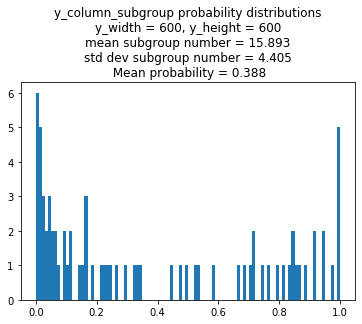

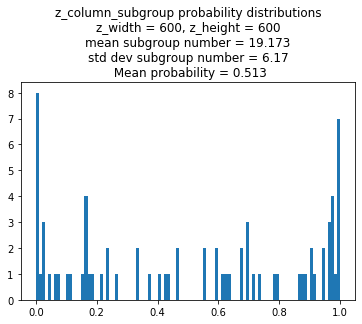

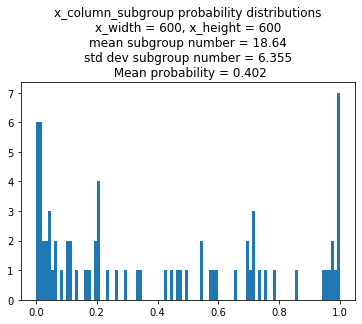

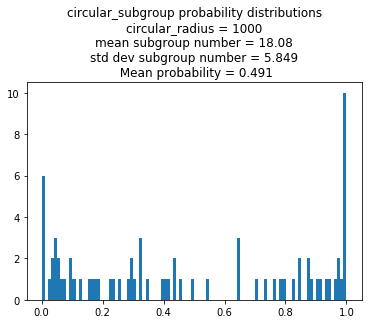

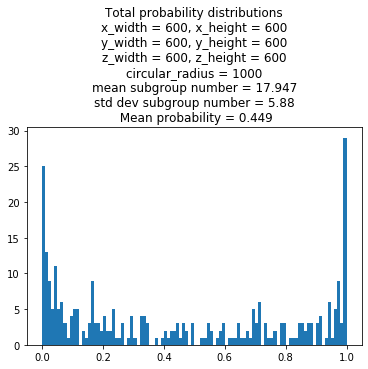

In [77]:
"""
Have to rerun this in order to get the necessary probability data

"""
import time
import random
def calc_mse(restricted_neuron_group,
             target_scaled
            ):
    
    restricted_neuron_group_orientation_preference = np.array([seg_id_to_orientation[k] for k in restricted_neuron_group])

    #now to get the total list shifted by subtracting off the target neuron
    total_neurons_scaled = restricted_neuron_group_orientation_preference*2

    differences = pycs.pairwise_cdiff(total_neurons_scaled,target_scaled)/2
    squared_difference = np.mean(differences**2)
    
    return squared_difference

mse_data = dict()
#target_neuron = 648518346341371119
start_time = time.time()
for target_neuron in soma_cell_location_dict.keys():
    

    mse_data[target_neuron] = dict()

    target_neuron_orientation_preferene = seg_id_to_orientation[target_neuron]


    target_scaled = target_neuron_orientation_preferene*2
    """
    Example of how to find neurons within a certain radius
    """
    total_neurons_list = list(soma_cell_location_dict.keys())
    total_neurons_list.remove(target_neuron)

    """
    Example of how to find neurons within x column
    """

    # test 1
    y_width = y_height = 600
    z_width = z_height = 600
    x_width = x_height = 600
    circular_radius = 1000
    
    width_axis = "x_distance"; height_axis = "z_distance"
    y_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,y_width,y_height,scaled=scale_flag)

    
    width_axis = "x_distance"; height_axis = "y_distance"
    z_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,z_width,z_height,scaled=scale_flag)

    
    width_axis = "y_distance"; height_axis = "z_distance"
    x_column_subgroup = find_column_subgroup(width_axis,height_axis,target_neuron,total_neurons_list,x_width,x_height,scaled=scale_flag)

    
    circular_subgroup = find_radius_subgroup(target_neuron,total_neurons_list,circular_radius,scaled=scale_flag)


    subgroups_list = dict(y_column_subgroup=y_column_subgroup,
                         z_column_subgroup=z_column_subgroup,
                         x_column_subgroup=x_column_subgroup,
                         circular_subgroup=circular_subgroup)

    n_random_shuffles = 1000


    
    for subgroup_name,restricted_neuron_group in subgroups_list.items():
        #get the mse of that subgroup
        restricted_neuron_group_mse = calc_mse(restricted_neuron_group,
                                              target_scaled)
        outside_neurons = [k for k in total_neurons_list if 
                       ((k not in restricted_neuron_group) and 
                        k != target_neuron)]
#         print("len(restricted_neuron_group) = " + str(len(restricted_neuron_group)))
#         print("len(outside_neurons) = " + str(len(outside_neurons)))
        
        random_shuffles_mse = []
        for i in range(0,n_random_shuffles):
            #get a random list from outside the subgroup
            if len(restricted_neuron_group) < len(outside_neurons):
                outside_neurons_rand = random.sample(outside_neurons,len(restricted_neuron_group))
            else:
                if i == 1:
                    print("not using sampling")
                outside_neurons_rand = outside_neurons
            
            if len(restricted_neuron_group) < len(outside_neurons_rand):
                print("RESTRICTED GROUP NUMBER IS LESS")
            random_shuffles_mse.append(calc_mse(outside_neurons_rand,
                                              target_scaled))

        #save the random shuffles
        mse_data[target_neuron][subgroup_name] = dict() 
        mse_data[target_neuron][subgroup_name]["shuffles"] = random_shuffles_mse
        mse_data[target_neuron][subgroup_name]["real_group"] = restricted_neuron_group_mse
        mse_data[target_neuron][subgroup_name]["real_group_len"] = len(restricted_neuron_group)
        
        probability_less_than = np.sum(random_shuffles_mse<restricted_neuron_group_mse)/len(random_shuffles_mse)
        mse_data[target_neuron][subgroup_name]["probability"] = probability_less_than
print(f"Total time for neurons = " + str(time.time() - start_time))


x_parameter_string = f"x_width = {x_width}, x_height = {x_height}"
y_parameter_string = f"y_width = {y_width}, y_height = {y_height}"
z_parameter_string = f"z_width = {z_width}, z_height = {z_height}"
sphere_parameter_string = f"circular_radius = {circular_radius}"


whole_parameters_string = "\n"+x_parameter_string+ \
                            "\n"+y_parameter_string+ \
                            "\n"+z_parameter_string+ \
                            "\n"+sphere_parameter_string

parameter_strings = [y_parameter_string,z_parameter_string,x_parameter_string,
                    sphere_parameter_string]

whole_parameters_string

#get all of the probabilities for each group

column_sphere_names = subgroups_list.keys()
total_probabilities = []
total_group_number = []
column_sphere_subgroup_number = dict()
column_sphere_probabilities = dict()
for volume_name,param in zip(column_sphere_names,parameter_strings):
    column_sphere_probabilities[volume_name] = []
    column_sphere_subgroup_number[volume_name] = []
    for a in mse_data.keys():
            column_sphere_probabilities[volume_name].append(mse_data[a][volume_name]["probability"])
            column_sphere_subgroup_number[volume_name].append(mse_data[a][volume_name]["real_group_len"])
    plt.figure()
    plt.hist(column_sphere_probabilities[volume_name],bins=100)
    mean_group_number = np.mean(column_sphere_subgroup_number[volume_name])
    std_dev_group_number = np.std(column_sphere_subgroup_number[volume_name])
    plt.title(volume_name  + " probability distributions\n" + param 
                           + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
                           + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
                            + "\n Mean probability = " + str(np.round(np.mean(column_sphere_probabilities[volume_name]),3)))
    total_group_number += column_sphere_subgroup_number[volume_name]
    total_probabilities += column_sphere_probabilities[volume_name]
    
    
mean_group_number = np.mean(total_group_number)
std_dev_group_number = np.std(total_group_number)

plt.figure()
plt.hist(total_probabilities,bins=100)
plt.title("Total probability distributions" + whole_parameters_string
         + "\nmean subgroup number = " + str(np.round(mean_group_number,3))
         + "\nstd dev subgroup number = " + str(np.round(std_dev_group_number,3))
         + "\n Mean probability = " + str(np.round(np.mean(total_probabilities),3)))

# Circular Clustering

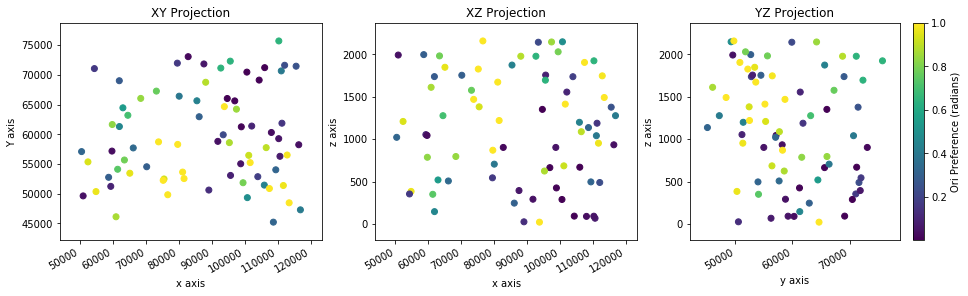

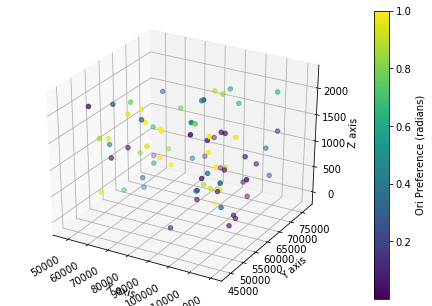

In [78]:
circular_col_values = [mse_data[a]["circular_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

print_3D_visuals(soma_centers_list,circular_col_values,-1,-1)

# Y Column Clustering

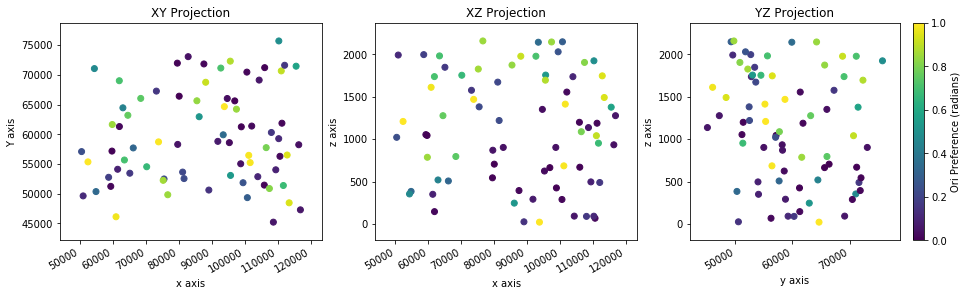

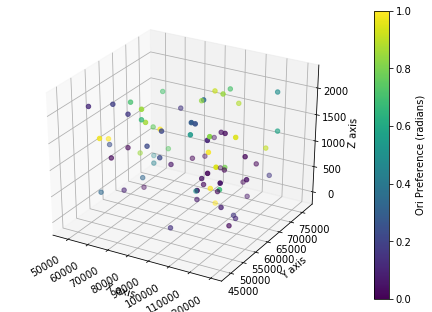

In [79]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
y_col_values = [mse_data[a]["y_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

print_3D_visuals(soma_centers_list,y_col_values,-1,-1)

# Z Column Clustering

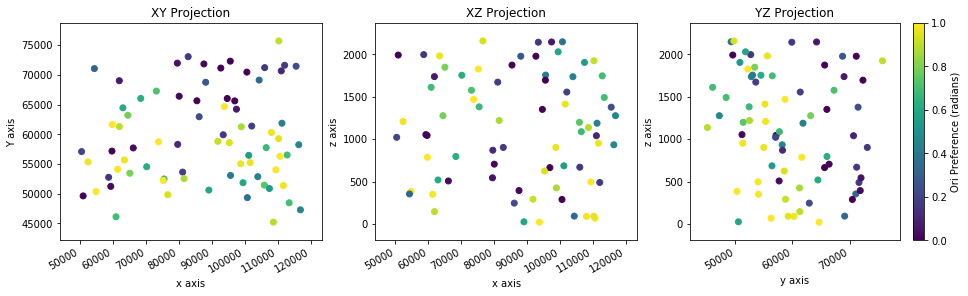

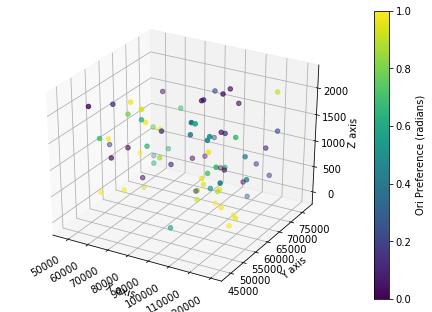

In [80]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
z_col_values = [mse_data[a]["z_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

print_3D_visuals(soma_centers_list,z_col_values,-1,-1)

# X column clustering

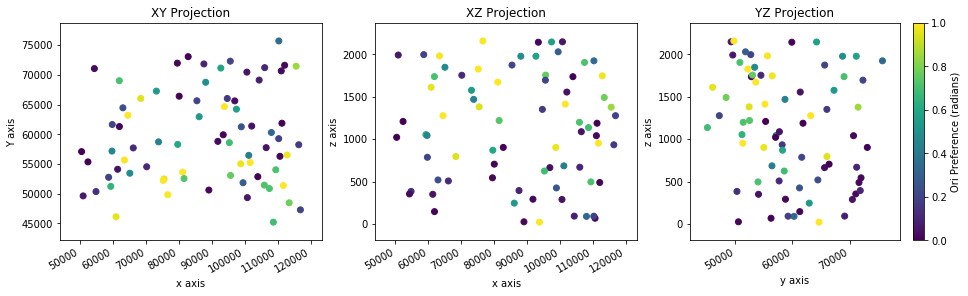

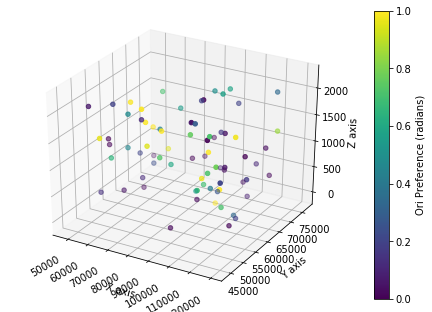

In [81]:
#Total groups = ['y_column_subgroup', 'z_column_subgroup', 'x_column_subgroup', 'circular_subgroup']
x_col_values = [mse_data[a]["x_column_subgroup"]["probability"] for a in soma_cell_location_dict.keys()]
soma_centers_list =  np.array([soma_cell_location_dict[a]["location"] for a in soma_cell_location_dict.keys()])

print_3D_visuals(soma_centers_list,x_col_values,-1,-1)